In [55]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
sns.set_style("darkgrid", {'axes.grid' : False})

In [56]:
iris = load_iris()
df = pd.DataFrame(iris.data)
df['label'] = iris.target
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


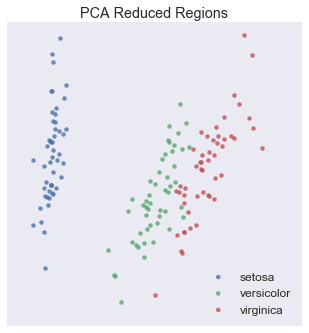

In [61]:
pca = PCA(n_components=2)
reduced = pca.fit(iris.data, iris.target).transform(iris.data)
reduced_df = pd.DataFrame(reduced)
reduced_df['label'] = iris.target
reduced_df.columns = ['PCA1', 'PCA2', 'label']
fg = sns.lmplot('PCA1', 'PCA2', data=reduced_df, hue='label', fit_reg=False, legend=False)
fg.set(ylim=[-1.5, 1.5])
fg.fig.suptitle('PCA Reduced Regions', size='x-large', x=0.55, y=.9998)
fg.ax.legend(labels=iris.target_names, loc='lower right', fontsize='large')
fg.ax.set_xticks([]) 
fg.ax.set_yticks([])
fg.ax.set_xlabel('')
fg.ax.set_ylabel('')

/Users/Chase/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


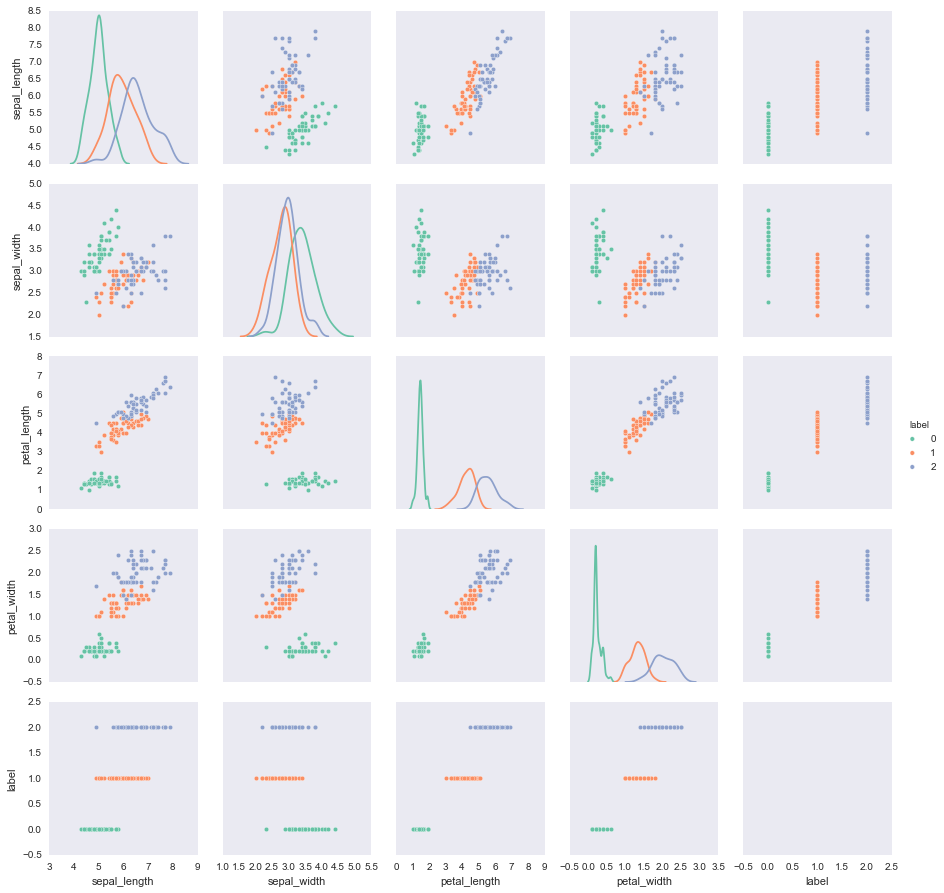

In [58]:
g = sns.pairplot(df, hue="label", palette="Set2", diag_kind="kde", size=2.5)

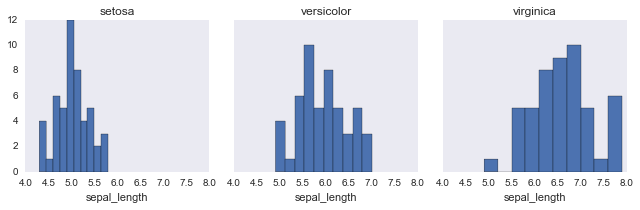

In [59]:
g = sns.FacetGrid(df, col='label')
g.map(plt.hist, 'sepal_length')
for ax, title in zip(g.axes.flat, iris.target_names):
    ax.set_title(title)

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
5,5.4,3.9
6,4.6,3.4
7,5.0,3.4
8,4.4,2.9
9,4.9,3.1


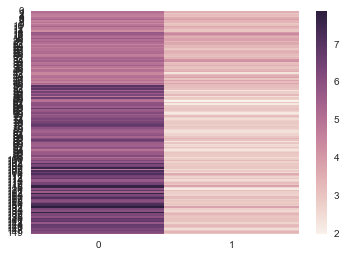